# Preparation

In [3]:
# Import primary functions
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import secondary functions
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from optuna.integration import CatBoostPruningCallback
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss
from sklearn.model_selection import (train_test_split, cross_val_score, KFold, 
                                     RepeatedStratifiedKFold, GridSearchCV)
from sklearn.preprocessing import StandardScaler

# Define pandas's column setting
pd.set_option('display.max_columns', None)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Analyze and prepare data

In [4]:
# Load the data directory
train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')

test_id = test.Id.copy()
train_max_index = train.shape[0]

y = train.Class.copy()
X = train.drop(['Id', 'Class'], axis=1).copy()
test = test.drop('Id', axis=1).copy()
X_full = pd.concat([X, test], axis=0).reset_index(drop=True)
X_full.columns = X_full.columns.str.strip()

X_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 56 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AB      622 non-null    float64
 1   AF      622 non-null    float64
 2   AH      622 non-null    float64
 3   AM      622 non-null    float64
 4   AR      622 non-null    float64
 5   AX      622 non-null    float64
 6   AY      622 non-null    float64
 7   AZ      622 non-null    float64
 8   BC      622 non-null    float64
 9   BD      622 non-null    float64
 10  BN      622 non-null    float64
 11  BP      622 non-null    float64
 12  BQ      562 non-null    float64
 13  BR      622 non-null    float64
 14  BZ      622 non-null    float64
 15  CB      620 non-null    float64
 16  CC      619 non-null    float64
 17  CD      622 non-null    float64
 18  CF      622 non-null    float64
 19  CH      622 non-null    float64
 20  CL      622 non-null    float64
 21  CR      622 non-null    float64
 22  CS

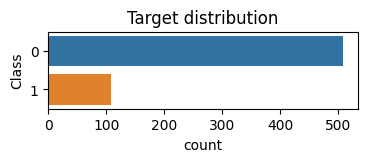

In [5]:
# Target distribution plot
plt.figure(figsize=(4, 1))
plt.title('Target distribution')
sns.countplot(y='Class', data=train)
plt.show()

# Correlation to target

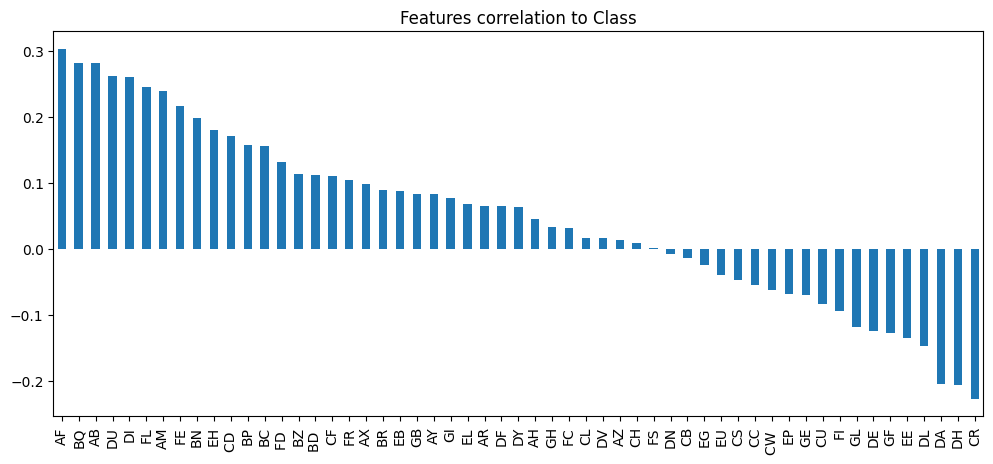

In [6]:
# Correlation graph
correlation = train.corr(numeric_only=True)['Class'].sort_values(ascending=False)
correlation[1:].plot(kind='bar', figsize=(12,5), title='Features correlation to Class')
plt.show()

# Analyze for multicolliniarity

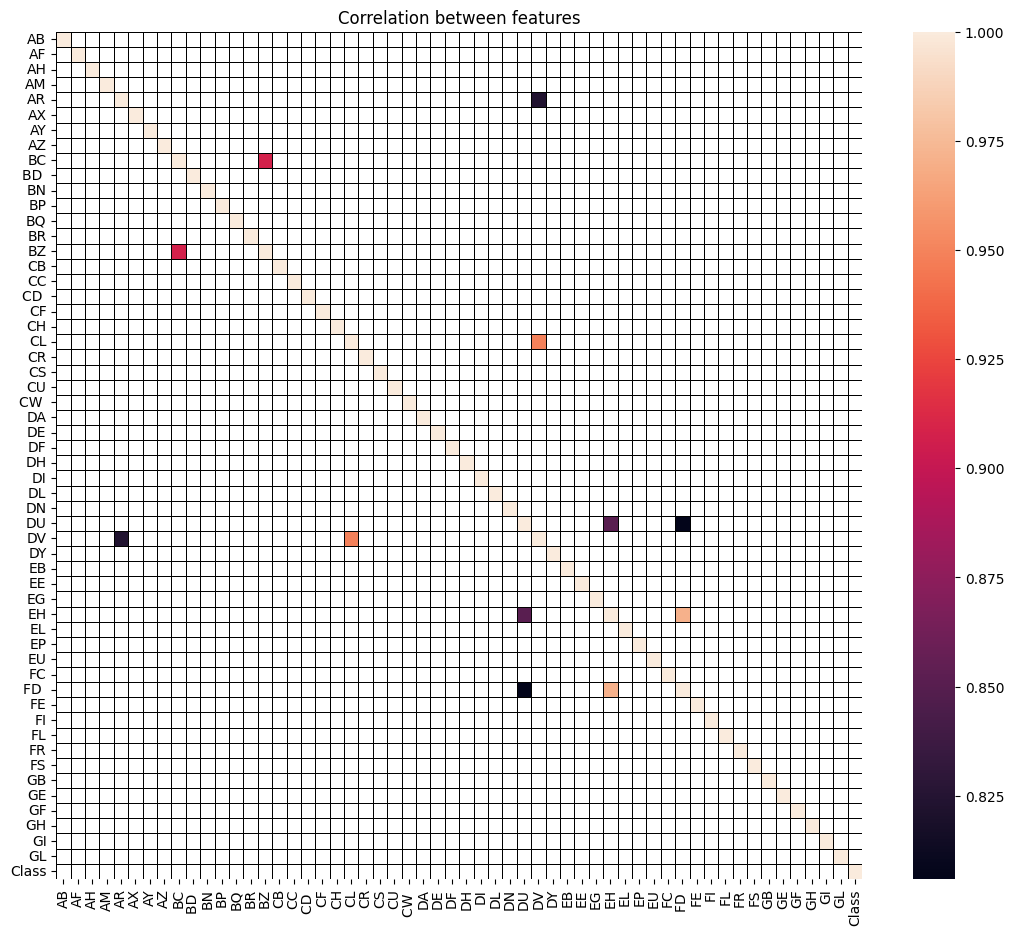

In [7]:
# Colliniarity heatmap
corr = train.corr(numeric_only=True)
plt.figure(figsize=(13, 11))
sns.heatmap(corr, mask=(corr<0.8), linewidths=.5, linewidth=0.7,linecolor='black', annot=False)

plt.title('Correlation between features')
plt.show()

# Features' instances

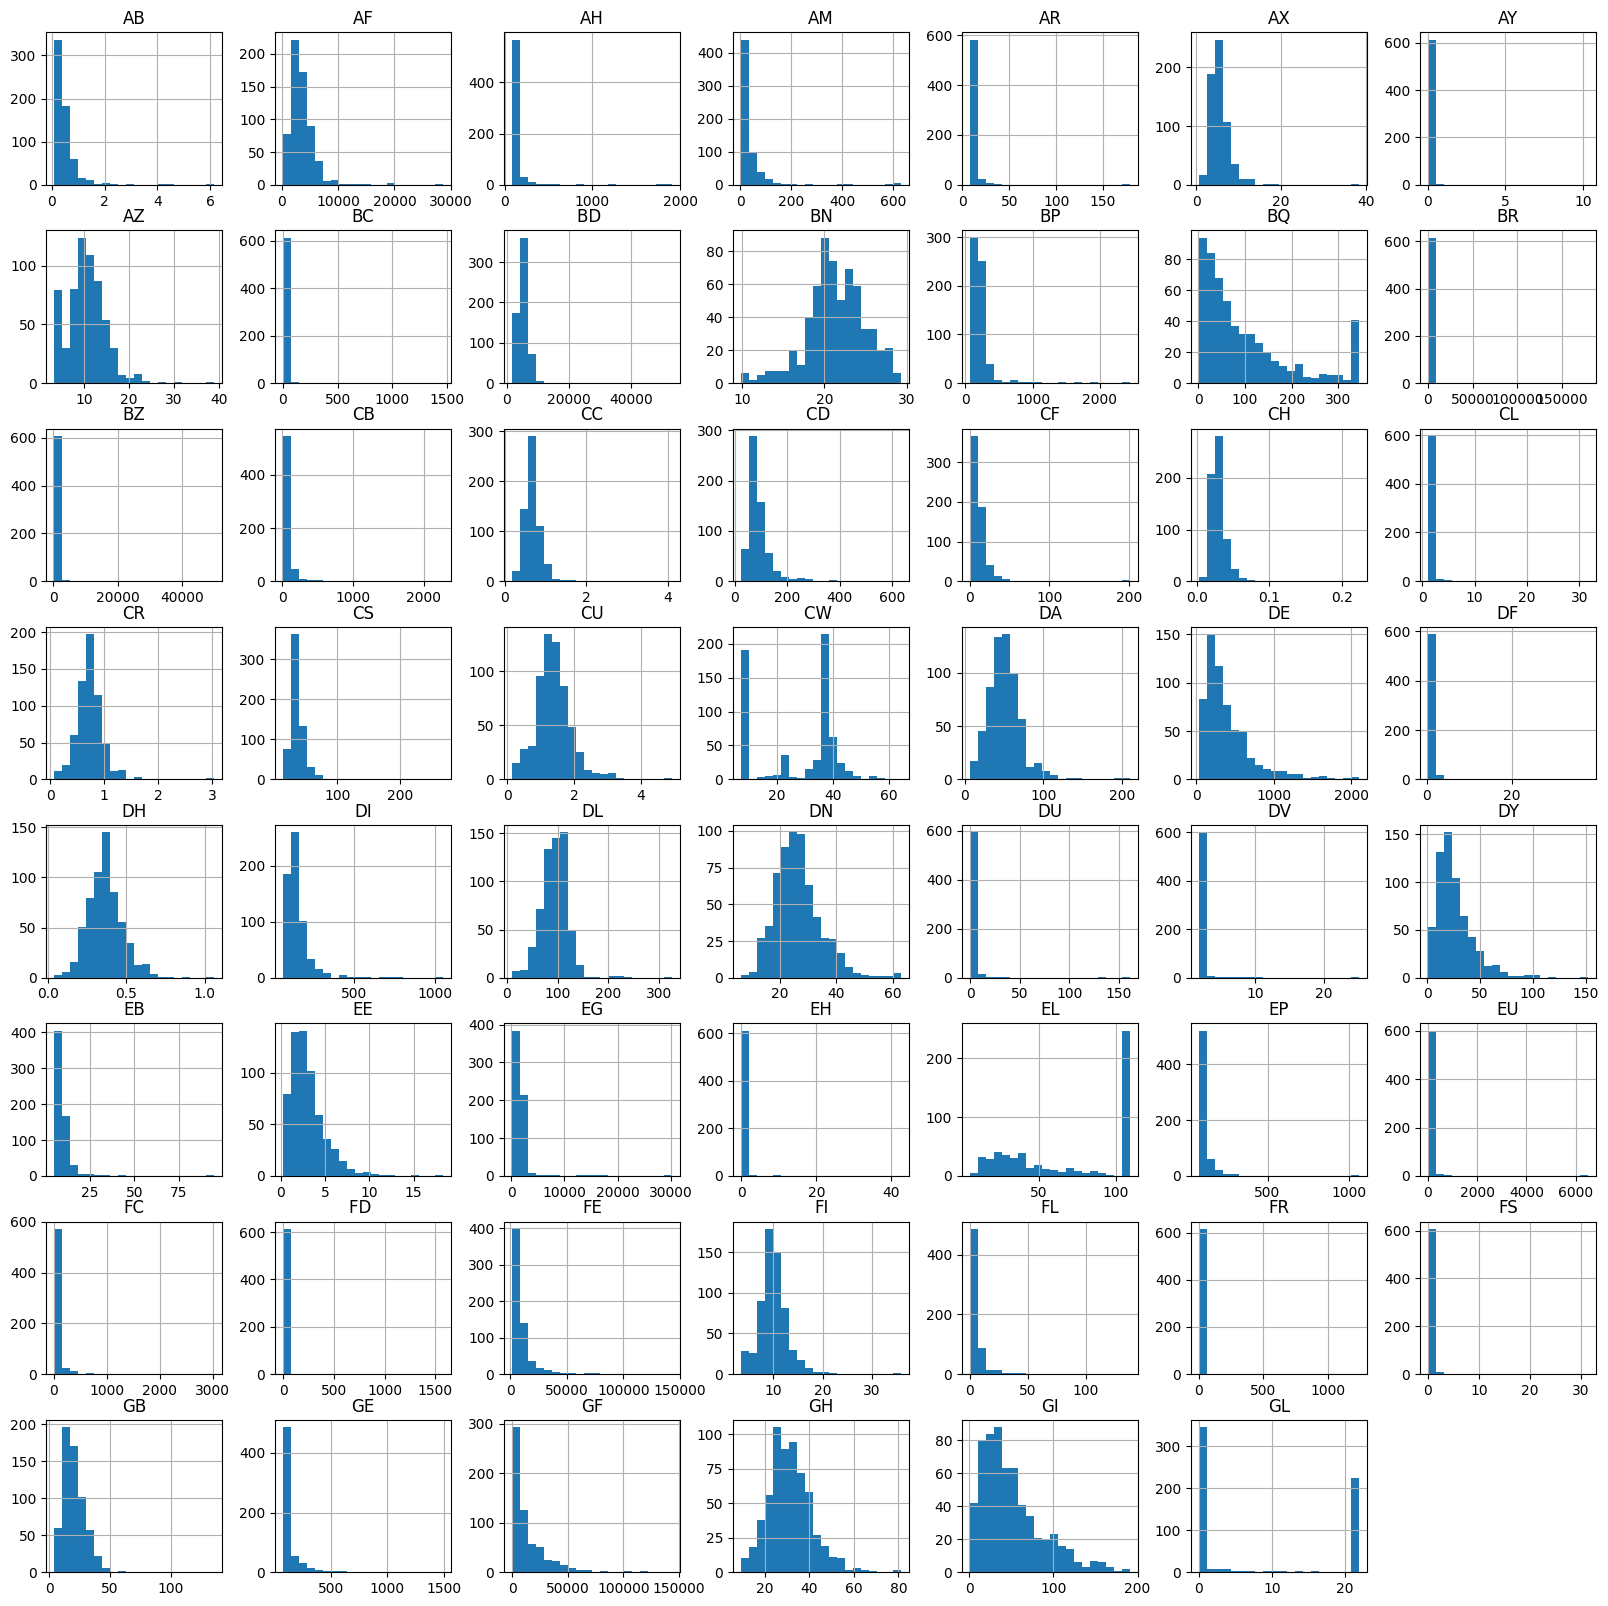

In [8]:
X.hist(bins=20, figsize=(20, 20))
plt.show()

# Analyze outliers

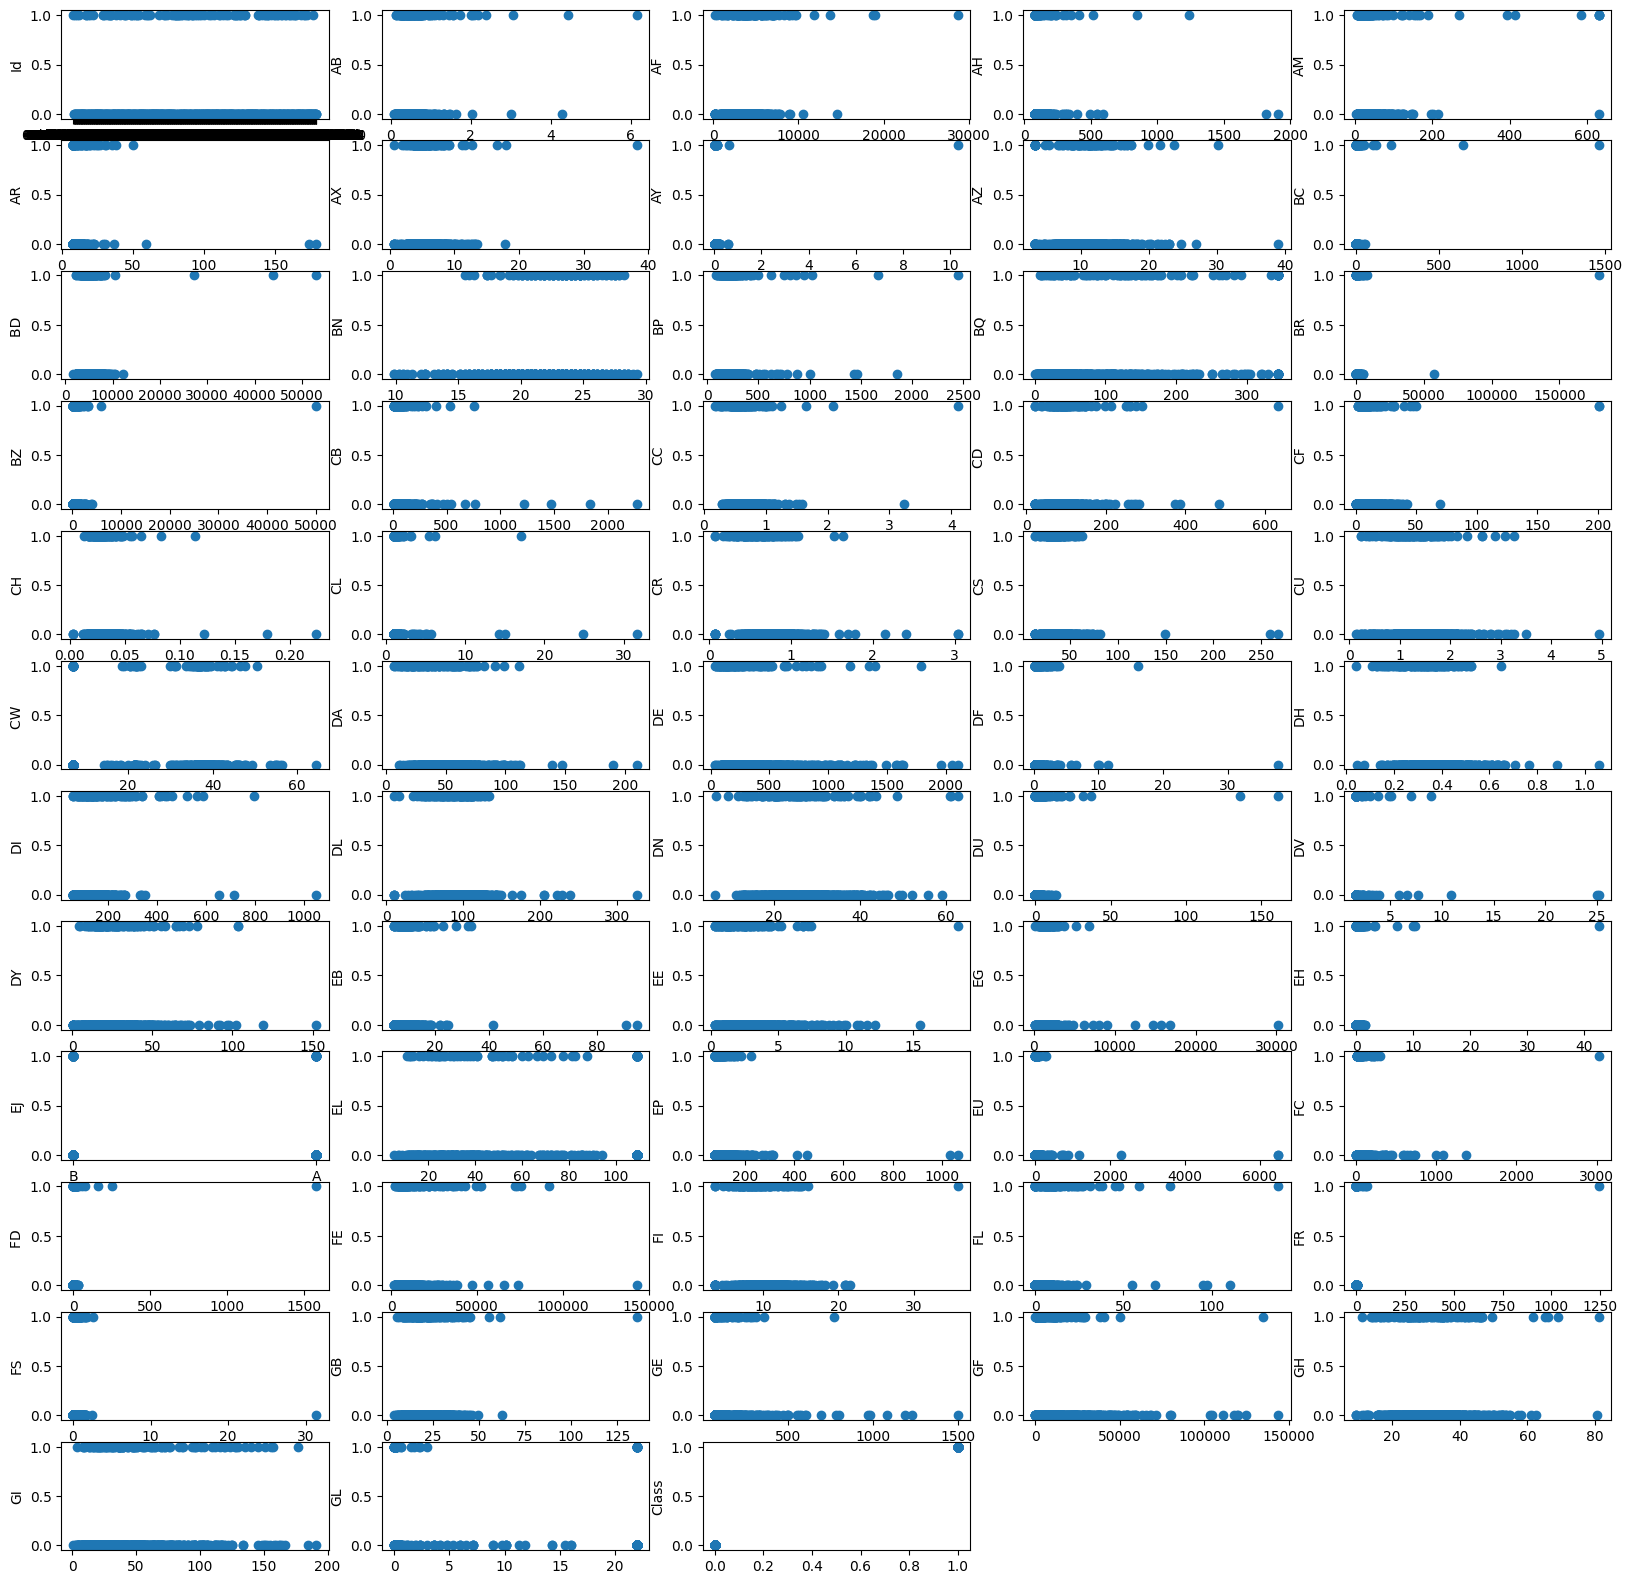

In [9]:
rows = (len(train.columns) // 5) + 1
cols = 5
count = 1  

fig = plt.figure(figsize=(20, 20))

for i in train.columns:
    plt.subplot(rows, cols, count)
    plt.scatter(train[i], train.Class)
    plt.ylabel(i)    
    count += 1 

plt.show()

In [10]:
# Cap the outliers
X_full.loc[X_full.AF.gt(20000), 'AF'] = 20000
X_full.loc[X_full.AR.gt(100), 'AR'] = 100
X_full.loc[X_full.AX.gt(20), 'AX'] = 20
X_full.loc[X_full.AY.gt(1), 'AY'] = 1
X_full.loc[X_full.BC.gt(1000), 'BC'] = 1000
X_full.loc[X_full.BR.gt(70000), 'BR'] = 70000
X_full.loc[X_full.BZ.gt(10000), 'BZ'] = 10000
X_full.loc[X_full.CD.gt(600), 'CD'] = 600
X_full.loc[X_full.CF.gt(100), 'CF'] = 100
X_full.loc[X_full.DF.gt(20), 'DF'] = 20
X_full.loc[X_full.DI.gt(1000), 'DI'] = 1000
X_full.loc[X_full.DL.gt(300), 'DL'] = 300
X_full.loc[X_full.DU.gt(100), 'DU'] = 100
X_full.loc[X_full.DV.gt(15), 'DV'] = 15
X_full.loc[X_full.DY.gt(150), 'DY'] = 150
X_full.loc[X_full.EB.gt(60), 'EB'] = 60
X_full.loc[X_full.EG.gt(20000), 'EG'] = 20000
X_full.loc[X_full.EH.gt(20), 'EH'] = 20
X_full.loc[X_full.EP.gt(600), 'EP'] = 600
X_full.loc[X_full.EU.gt(3000), 'EU'] = 3000
X_full.loc[X_full.FC.gt(2000), 'FC'] = 2000
X_full.loc[X_full.FD.gt(500), 'FD'] = 500
X_full.loc[X_full.FE.gt(120000), 'FE'] = 120000
X_full.loc[X_full.FI.gt(25), 'FI'] = 25
X_full.loc[X_full.FR.gt(100), 'FR'] = 100
X_full.loc[X_full.FS.gt(5), 'FS'] = 5
X_full.loc[X_full.GB.gt(80), 'GB'] = 80

# Encode and impute

In [11]:
# Encode categoricals
X_full = pd.get_dummies(X_full)

# Impute missing values
imp = SimpleImputer(strategy='mean')
X_full = pd.DataFrame(imp.fit_transform(X_full), columns=X_full.columns)

# Feature engineering

In [12]:
# Exclude most-correlated features
drop_cols = ['BZ', 'DV', 'EH', 'FD']
X_full = X_full.drop(drop_cols, axis=1)

# Create the entire data frame for analysis
X = X_full[:train_max_index]
target = pd.get_dummies(greeks.Alpha)
full_df = pd.concat([X, y, greeks, target], axis=1).drop(['Id', 'Epsilon'], axis=1)

In [13]:
full_df.groupby('Alpha').describe()

AB                                                              \
       count      mean       std       min       25%       50%       75%   
Alpha                                                                      
A      509.0  0.416655  0.325706  0.081187  0.239288  0.333294  0.499941   
B       61.0  0.551917  0.492800  0.132463  0.311929  0.423027  0.636677   
D       18.0  1.013176  1.363654  0.132463  0.467893  0.583265  0.740297   
G       29.0  1.048948  0.806473  0.465757  0.615312  0.756321  1.008428   

                    AF                                                     \
            max  count         mean          std         min          25%   
Alpha                                                                       
A      4.277273  509.0  3181.597632  1677.157950   192.59328  2072.223010   
B      3.068014   61.0  4304.971515  3131.979694   192.59328  2833.553800   
D      6.161666   18.0  5234.604528  3902.546833  1070.72900  3372.526822   
G      4.435374   29.0  6061.883827  3192.298649  1766.78392  4156.192700   

                                                AH                          \
              50%          75%          max  count        mean         std   
Alpha                                                                        
A      2919.81954  4059.436260  14503.25602  509.0  115.997626  123.507052   
B      3753.04248  4877.541460  20000.00000   61.0  110.577531   78.869684   
D      4766.17548  5700.237097  18964.47278   18.0  122.040185   73.456834   
G      5192.25520  7040.370480  18720.82960   29.0  179.537236  249.134668   

                                                                    AM  \
             min        25%        50%         75%          max  count   
Alpha                                                                    
A      85.200147  85.200147  85.200147  114.923964  1910.123198  509.0   
B      85.200147  85.200147  85.200147   85.200147   514.858662   61.0   
D      85.200147  85.200147  85.200147  115.041535   355.100766   18.0   
G      85.200147  85.200147  93.813348  145.710279  1237.940805   29.0   

                                                                         \
            mean         std       min        25%        50%        75%   
Alpha                                                                     
A      31.292888   39.542608  3.177522  11.957517  19.405802  35.757962   
B      68.925512  128.595835  6.073217  13.180832  21.960827  43.596469   
D      83.129072  143.383098  6.472730  25.086474  37.386210  77.825287   
G      83.266796  156.094893  7.002317  21.291875  30.285563  52.871984   

                     AR                                                     \
             max  count       mean       std       min       25%       50%   
Alpha                                                                        
A      630.51823  509.0   9.516988  6.736182  8.138688  8.138688  8.138688   
B      630.51823   61.0  11.965089  8.197101  8.138688  8.138688  8.138688   
D      630.51823   18.0  11.054352  7.344934  8.138688  8.138688  8.138688   
G      630.51823   29.0  11.160407  4.891629  8.138688  8.138688  8.138688   

                                 AX                                          \
             75%         max  count      mean       std       min       25%   
Alpha                                                                         
A       8.138688  100.000000  509.0  5.430932  2.107305  0.699861  4.101717   
B      10.760688   50.253252   61.0  5.267560  2.673288  0.699861  3.844806   
D       8.138688   37.987536   18.0  6.891810  4.031226  3.698632  4.557955   
G      13.380066   26.712936   29.0  6.676937  1.952677  3.632190  5.248958   

                                         AY                                \
            50%       75%        max  count      mean       std       min   
Alpha                                                                       
A      4.9964

In [14]:
# Kernel Density Estimation (KDE), 1st step
def target_by_df_plus(feature, xticks=None, xlim=None):
    class_0 = full_df[full_df.Alpha == 'A']
    class_1_B = full_df[full_df.Alpha == 'B']
    class_1_D = full_df[full_df.Alpha == 'D']
    class_1_G = full_df[full_df.Alpha == 'G']

    plt.figure(figsize=(12, 4))
    
    class_0[feature].plot(kind='kde', label='Class_0_A')
    class_1_B[feature].plot(kind='kde', label='Class_1_B')
    class_1_D[feature].plot(kind='kde', label='Class_1_D')
    class_1_G[feature].plot(kind='kde', label='Class_1_G')
    
    plt.xlim(xlim)
    plt.xticks(xticks)
    plt.legend()
    plt.grid()
    plt.xlabel(feature)
    plt.show()

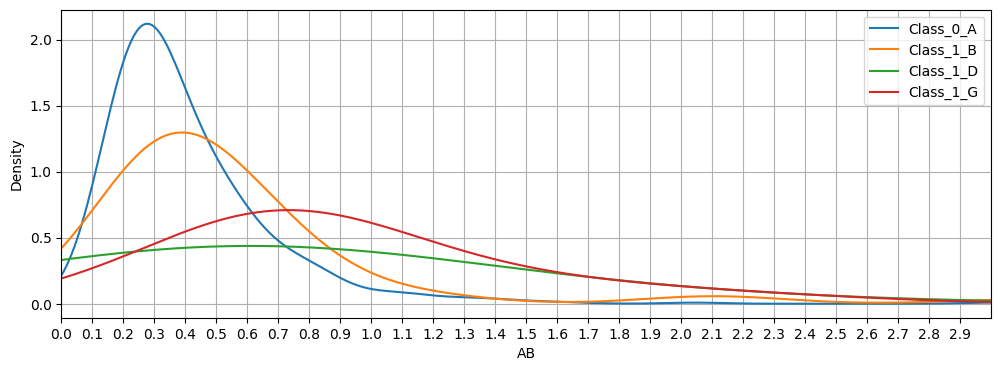

In [15]:
# Class separation by AB
target_by_df_plus('AB', np.arange(0, 3, 0.1), (0, 3))

In [16]:
# Create AB_groups feature
X_full['AB_groups'] = pd.cut(x=X_full.AB, labels=[0, 1, 3, 2],
                            bins=[-1, 0.47, 0.61, 0.72, X_full.AB.max()]).astype('float')

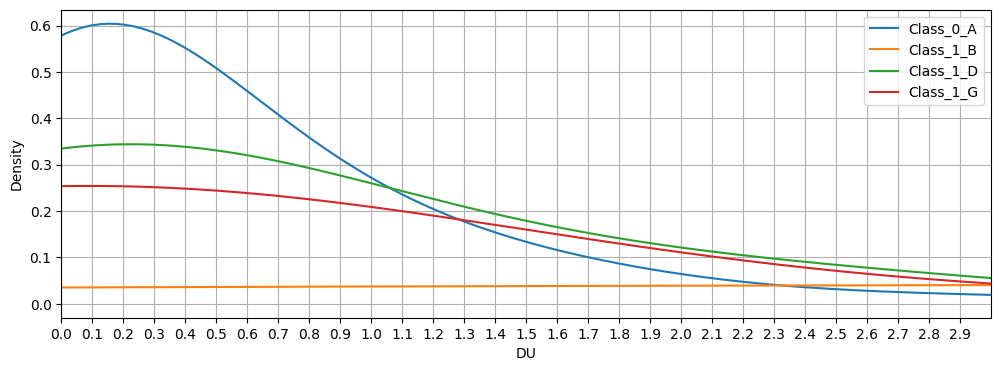

In [17]:
# Class separation by DU
target_by_df_plus('DU', np.arange(0, 3, 0.1), (0, 3))

In [18]:
# Create DU_groups feature
X_full['DU_groups'] = pd.cut(x=X_full.DU, labels=[0, 2, 3, 1],
                            bins=[-1, 1.05, 1.25, 2.3, X_full.DU.max()]).astype('float')

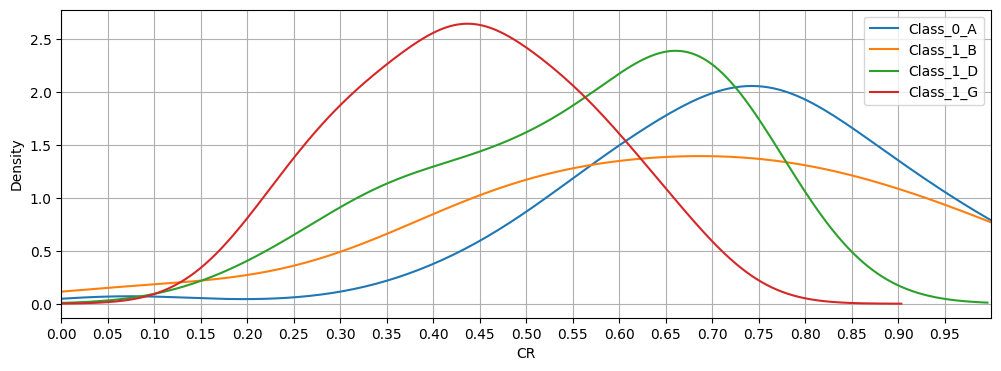

In [19]:
# Class separation by CR
target_by_df_plus('CR', np.arange(0, 1, 0.05), (0, 1))

In [20]:
# Create CR_groups feature
X_full['CR_groups'] = pd.cut(x=X_full.CR, labels=[1, 3, 2, 0],
                            bins=[-1, 0.56, 0.61, 0.72, X_full.CR.max()]).astype('float')

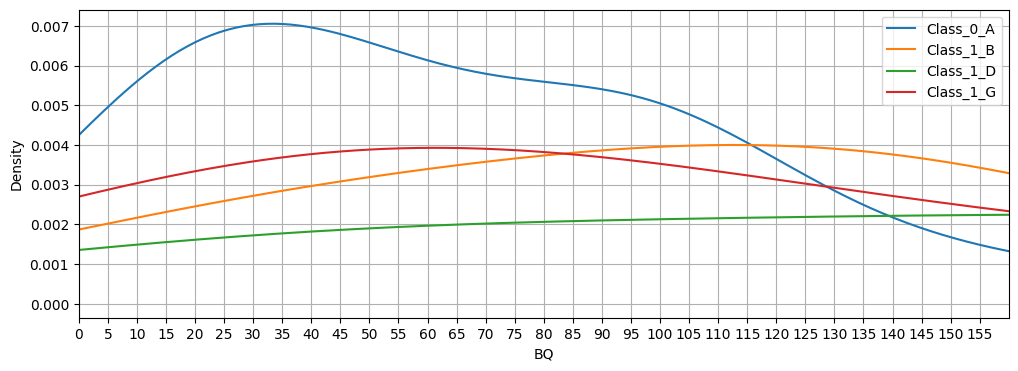

In [21]:
# Class separation by BQ
target_by_df_plus('BQ', np.arange(0, 160, 5), (0, 160))

In [22]:
# Create BQ_groups feature
X_full['BQ_groups'] = pd.cut(x=X_full.BQ, labels=[0, 1, 3, 2],
                            bins=[-1, 115, 128, 139, X_full.BQ.max()]).astype('float')

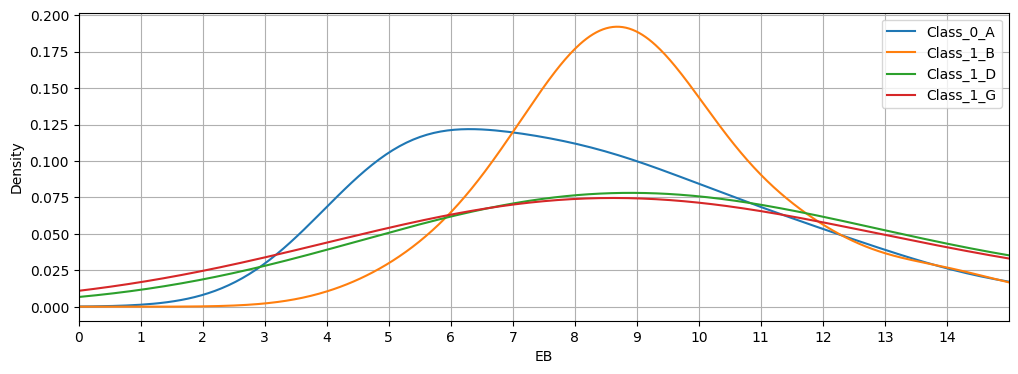

In [23]:
# Class separation by EB
target_by_df_plus('EB', np.arange(0, 15, 1), (0, 15))

In [24]:
# Create EB_groups feature
X_full['EB_groups'] = pd.cut(x=X_full.EB, labels=[0, 1, 2, 3],
                            bins=[-1, 7, 10.9, 11.2, X_full.EB.max()]).astype('float')

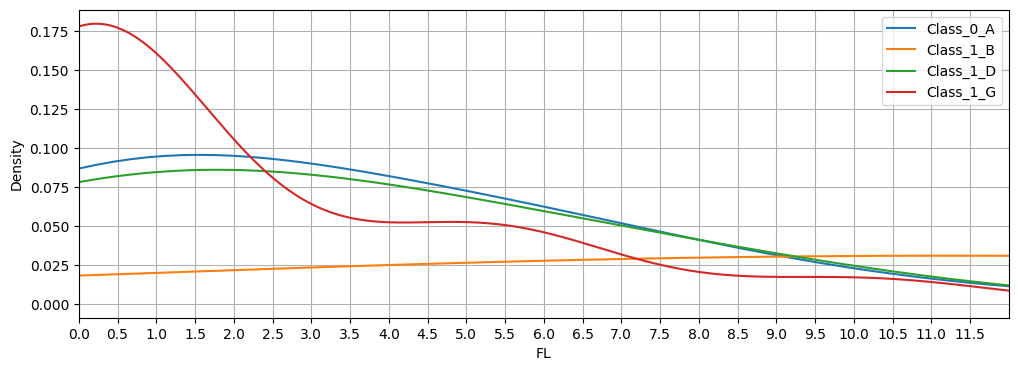

In [25]:
# Class separation by FL
target_by_df_plus('FL', np.arange(0, 12, 0.5), (0, 12))

In [26]:
# Create FL_groups feature
X_full['FL_groups'] = pd.cut(x=X_full.FL, labels=[3, 0, 2, 1],
                            bins=[-1, 2.2, 7, 9.1, X_full.FL.max()]).astype('float')

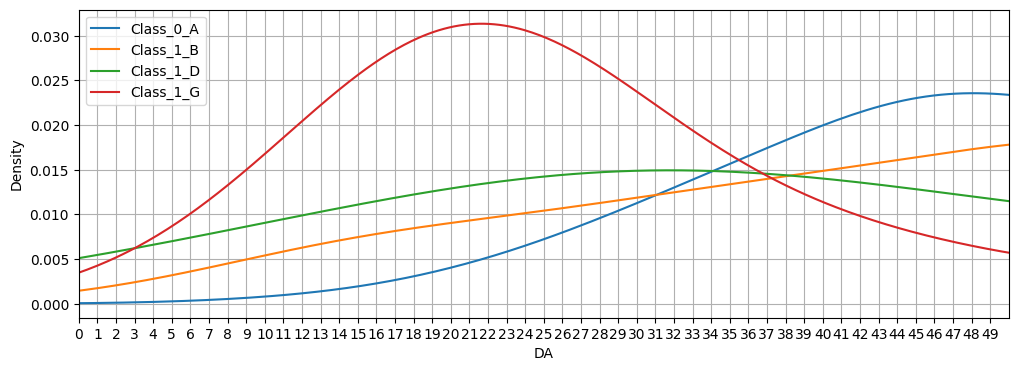

In [27]:
# Class separation by DA
target_by_df_plus('DA', np.arange(0, 50, 1), (0, 50))

In [28]:
# Create DA_groups feature
X_full['DA_groups'] = pd.cut(x=X_full.DA, labels=[1, 2, 3, 0],
                            bins=[-1, 31, 33, 35.5, X_full.DA.max()]).astype('float')

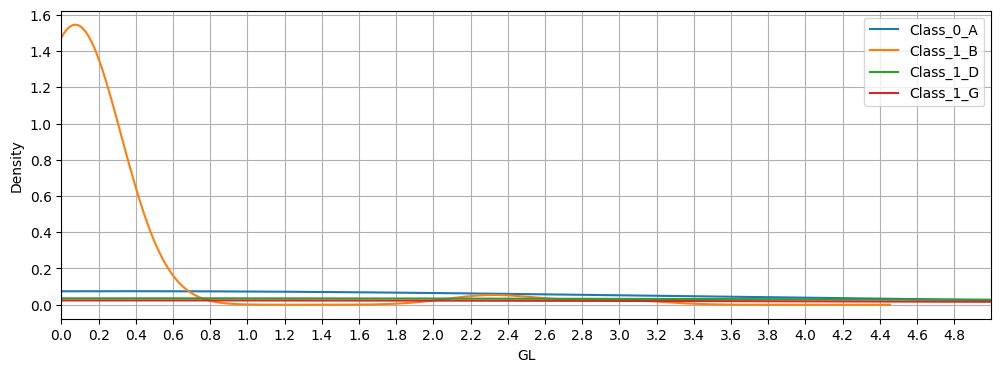

In [29]:
# Class separation by GL
target_by_df_plus('GL', np.arange(0, 5, 0.2), (0, 5))

In [30]:
# Create GL_groups feature
X_full['GL_groups'] = pd.cut(x=X_full.GL, labels=[1, 0],
                            bins=[-1, 0.7, X_full.GL.max()]).astype('float')

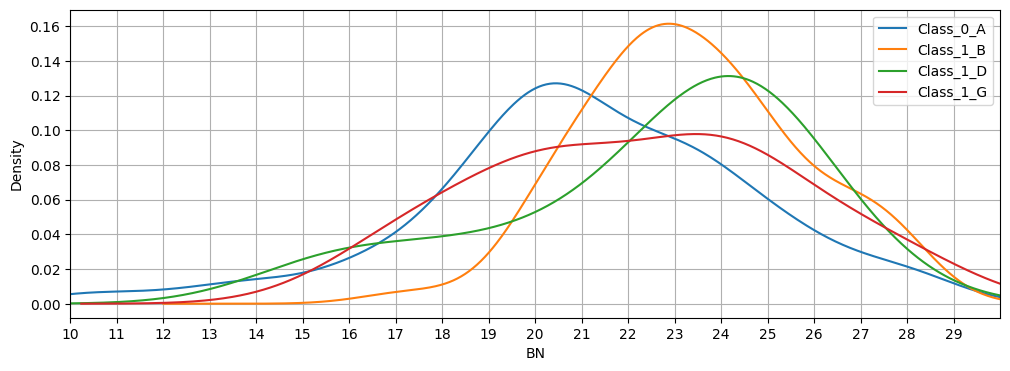

In [31]:
# Class separation by BN
target_by_df_plus('BN', np.arange(10, 30, 1), (10, 30))

In [32]:
# Create BN_groups feature
X_full['BN_groups'] = pd.cut(x=X_full.BN, labels=[0, 1, 2, 3],
                            bins=[-1, 21.2, 22.3, 22.9, X_full.BN.max()]).astype('float')

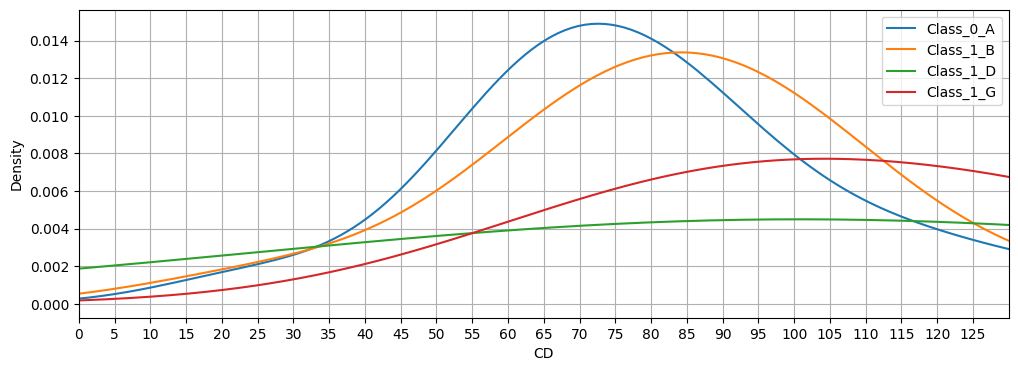

In [33]:
# Class separation by CD
target_by_df_plus('CD', np.arange(0, 130, 5), (0, 130))

In [34]:
# Create CD_groups feature
X_full['CD_groups'] = pd.cut(x=X_full.CD, labels=[0, 1, 3, 2],
                            bins=[-1, 83, 101, 117, X_full.CD.max()]).astype('float')

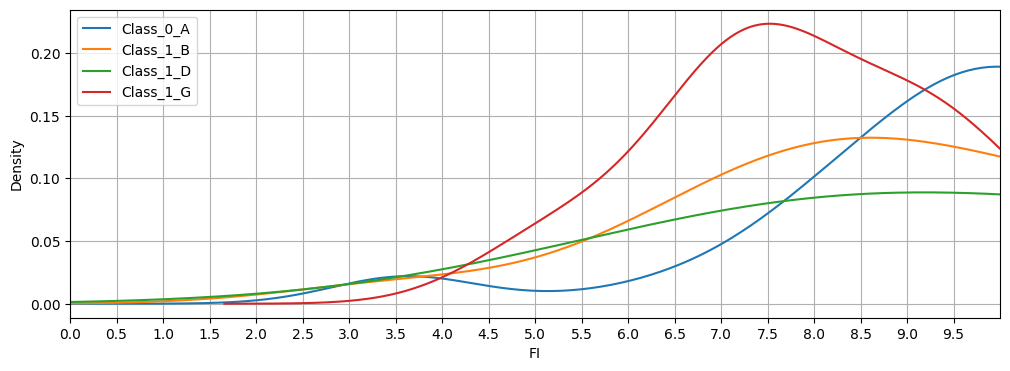

In [35]:
# Class separation by FI
target_by_df_plus('FI', np.arange(0, 10, 0.5), (0, 10))

In [36]:
# Create FI_groups feature
X_full['FI_groups'] = pd.cut(x=X_full.FI, labels=[2, 1, 3, 0],
                            bins=[-1, 7.7, 8.5, 9.2, X_full.FI.max()]).astype('float')

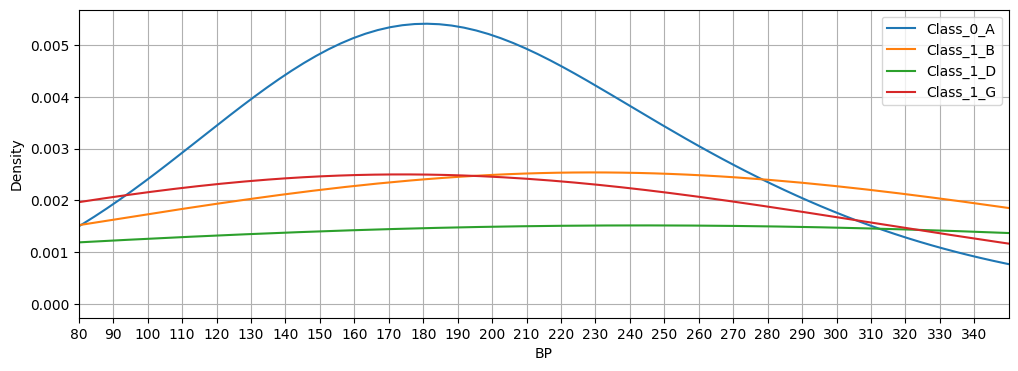

In [37]:
# Class separation by BP
target_by_df_plus('BP', np.arange(80, 350, 10), (80, 350))

In [38]:
# Create BP_groups feature
X_full['BP_groups'] = pd.cut(x=X_full.BP, labels=[0, 1, 3, 2],
                            bins=[-1, 278, 305, 312, X_full.BP.max()]).astype('float')

In [39]:
# Kernel Density Estimation (KDE), 2nd step
def target_by(feature, xticks=None, xlim=None):
    class_0 = full_df[full_df.Class == 0]
    class_1 = full_df[full_df.Class == 1]

    plt.figure(figsize=(8, 4))
    
    class_0[feature].plot(kind='kde', label='Class_0')
    class_1[feature].plot(kind='kde', label='Class_1')
    
    plt.xlim(xlim)
    plt.xticks(xticks)
    plt.legend()
    plt.grid()
    plt.xlabel(feature)
    plt.show()

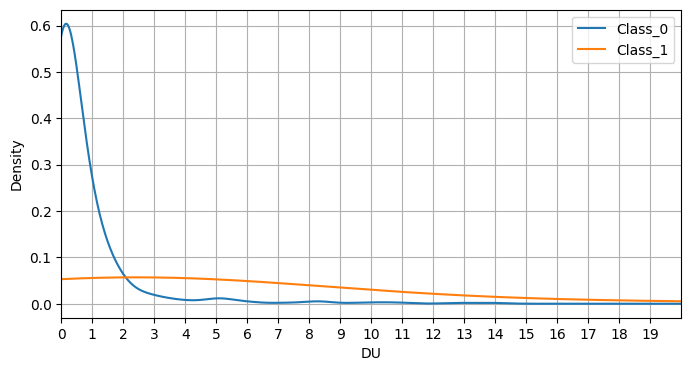

In [40]:
# Class separation by DU
target_by('DU', np.arange(0, 20, 1), (0, 20))

In [41]:
# Create DU_group feature
X_full['DU_group'] = pd.cut(x=X_full.DU, labels=[0, 1], bins=[-1, 2.1, X_full.DU.max()]).astype('float')

# Prepare data for modeling

In [42]:
# Standardization
std_scaler = StandardScaler()
X_full = pd.DataFrame(std_scaler.fit_transform(X_full), columns=X_full.columns)

# Split train and test data
X = X_full[:train_max_index]
test = X_full[train_max_index:]

# Oversampling with SMOTE
smote = SMOTE()
X, y = smote.fit_resample(X, y)

# Split train and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1, 
                                                  test_size=0.2, stratify=y)

X_plus = pd.concat([X, full_df[['A', 'B', 'D', 'G']]], axis=1)

# Catboost optuna tuning

In [43]:
def competition_log_loss(y_true, y_pred):
    # Calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # Calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # Calculate the average log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    # Return the average rate
    return (log_loss_0 + log_loss_1)/2

In [44]:
# Define function for CatBoostClassifier parameters search
def cat_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.00000001, 100.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 0.00000001, 10.0, log=True),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01, 0.1, log=True),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type': 'Bayesian',
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
        'objective': 'Logloss',
        'eval_metric': 'Logloss',
        'verbose': False,   
    }
    
    cat_model = CatBoostClassifier(**params)    
    cat_model.fit(X_train, y_train, verbose=0,)
    cat_preds = cat_model.predict_proba(X_val)
    
    return competition_log_loss(y_val, cat_preds[:, 1])

# XGBClassifier optuna tuning

In [45]:
# Define function for parameters search
def xgb_objective(trial):
    params = {'max_depth': trial.suggest_int('max_depth', 1, 9),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
            'subsample': trial.suggest_float('subsample', 0.01, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
            'eval_metric': 'logloss',
            }
    
    xgb_model = XGBClassifier(**params)  
    xgb_model.fit(X_train, y_train, verbose=0)   
    xgb_preds = xgb_model.predict_proba(X_val)
    
    return competition_log_loss(y_val, xgb_preds[:, 1])

# LGBMClassifier optuna tuning

In [46]:
# Define function for LGBMClassifier parameters search
def lgbm_objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    lgbm_model = LGBMClassifier(**params)  
    lgbm_model.fit(X_train, y_train)
    lgbm_preds = lgbm_model.predict_proba(X_val)
    
    return competition_log_loss(y_val, lgbm_preds[:, 1])

In [47]:
# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(cat_objective, n_trials=200)

# Show best results
trial = study.best_trial

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
print('Value:', trial.value)
print('Params:')

for key, value in trial.params.items():
    print('{}: {}'.format(key, value))

[I 2024-06-09 07:00:15,593] A new study created in memory with name: no-name-d6860bf6-e8fb-4a1e-9358-173379c9f4bd
[I 2024-06-09 07:00:17,639] Trial 0 finished with value: 0.10130179025553766 and parameters: {'iterations': 883, 'learning_rate': 0.06818433864409164, 'depth': 6, 'l2_leaf_reg': 3.7701091979033776e-07, 'random_strength': 0.8584313585333947, 'od_type': 'IncToDec', 'od_wait': 38, 'colsample_bylevel': 0.013487977961446325, 'boosting_type': 'Ordered', 'bagging_temperature': 6.775959767675012}. Best is trial 0 with value: 0.10130179025553766.
[I 2024-06-09 07:00:19,867] Trial 1 finished with value: 0.2610099394003353 and parameters: {'iterations': 943, 'learning_rate': 0.0018862576994137605, 'depth': 9, 'l2_leaf_reg': 2.230176077928879, 'random_strength': 9.805708968852862e-05, 'od_type': 'IncToDec', 'od_wait': 40, 'colsample_bylevel': 0.029531333199704725, 'boosting_type': 'Plain', 'bagging_temperature': 1.3526592561571738}. Best is trial 0 with value: 0.10130179025553766.
[I 2

Number of finished trials:  200
Best trial:
Value: 0.01466087521230484
Params:
iterations: 1312
learning_rate: 0.06035876188173233
depth: 7
l2_leaf_reg: 4.343336352905563e-06
random_strength: 5.463795424846188e-05
od_type: IncToDec
od_wait: 24
colsample_bylevel: 0.09255811660713174
boosting_type: Ordered
bagging_temperature: 7.352201862250041


# Models best parameters

In [48]:
# CatBoostClassifier parameters 
cat_params = {'iterations': 585,
              'learning_rate': 0.09012990155555568,
              'depth': 6,
              'l2_leaf_reg': 48.38687290206135,
              'random_strength': 4.111892977704381,
              'od_type': 'IncToDec',
              'od_wait': 19,
              'colsample_bylevel': 0.08333408198272105,
              'boosting_type': 'Ordered',
              'bagging_temperature': 1.7936737784972574,
              'bootstrap_type': 'Bayesian',
              'objective': 'Logloss',
              'loss_function': 'Logloss',
              'eval_metric': 'Logloss',
              'thread_count': -1, 
              'verbose': False,
              'auto_class_weights': 'Balanced',
              }

cat_model = CatBoostClassifier(**cat_params)

# XGBClassifier parameters
xgb_params = {'max_depth': 4,
            'learning_rate': 0.12136631254293247,
            'n_estimators': 142,
            'min_child_weight': 7,
            'gamma': 0.03587497885141243,
            'subsample': 0.9106476434831074,
            'colsample_bytree': 0.47329163464012913,
            'reg_alpha': 0.9764373212905214,
            'reg_lambda': 0.4308308924603539,
            'eval_metric': 'logloss',
            'scale_pos_weight': 5,
            }

xgb_model = XGBClassifier(**xgb_params)

# LGBMClassifier parameters
lgbm_params = {'objective': 'binary',
               'metric': 'binary_logloss',
               'verbose': -1,
               'boosting_type': 'gbdt',
               'lambda_l1': 0.01666365206445349,
               'lambda_l2': 2.397777201300923e-07,
               'num_leaves': 86,
               'feature_fraction': 0.5676772243600292,
               'bagging_fraction': 0.7385921819546152,
               'bagging_freq': 2,
               'min_child_samples': 72,
               'is_unbalance': True,
              }

lgbm_model = LGBMClassifier(**lgbm_params)

# Testing models

In [49]:
# Cross validation function
def cross_val(model, n_splits=5):
    cv = KFold(n_splits=n_splits, random_state=1, shuffle=True)
    scores = -cross_val_score(model, X, y, scoring='neg_log_loss', cv=cv)
    print(pd.Series(scores).describe())

In [50]:
# Cross validation function
def cross_val(model, n_splits=5):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, random_state=1)
    scores = -cross_val_score(model, X, y, scoring='neg_log_loss', cv=cv)
    print(pd.Series(scores).describe())

In [51]:
# Testing cat_model
cross_val(cat_model)

count    50.000000
mean      0.072617
std       0.018370
min       0.038745
25%       0.058737
50%       0.069480
75%       0.083852
max       0.131762
dtype: float64


In [52]:
# CatBoost 'auto_class_weights': 'Balanced' no SMOTE
# count    5.000000
# mean     0.150066
# std      0.031107
# min      0.108056
# 25%      0.138619
# 50%      0.144093
# 75%      0.170477
# max      0.189083

In [53]:
# Testing xgb_model
cross_val(xgb_model)

count    50.000000
mean      0.096719
std       0.024822
min       0.047191
25%       0.076395
50%       0.098008
75%       0.112050
max       0.165872
dtype: float64


In [54]:
# XGBoost scale_pos_weight=5 no SMOTE
# count    5.000000
# mean     0.173575
# std      0.033672
# min      0.128482
# 25%      0.147864
# 50%      0.188970
# 75%      0.195411
# max      0.207146

In [55]:
# Testing lgbm_model
cross_val(lgbm_model)

[LightGBM] [Warning] bagging_fraction is set=0.7385921819546152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7385921819546152
[LightGBM] [Warning] lambda_l1 is set=0.01666365206445349, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01666365206445349
[LightGBM] [Warning] feature_fraction is set=0.5676772243600292, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5676772243600292
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.397777201300923e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.397777201300923e-07
[LightGBM] [Warning] bagging_fraction is set=0.7385921819546152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7385921819546152
[LightGBM] [Warning] lambda_l1 is set=0.01666365206445349, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01666365206445349
[LightGBM] [Warning] feature_fract

In [56]:
# lgbm 'is_unbalance':True, no SMOTE
# count    5.000000
# mean     0.191119
# std      0.041235
# min      0.133224
# 25%      0.177851
# 50%      0.189904
# 75%      0.209240
# max      0.245374

# Blending models and predicting

In [57]:
# Function to fit and predict
def fit_predict(model, model_name):
    model.fit(X_train, y_train)
    preds_val = pd.DataFrame(
        model.predict_proba(X_val), 
        columns=[(model_name + '_preds_0'), 
                 (model_name + '_preds_1')]).set_index(X_val.index)
    
    preds_test = pd.DataFrame(
        model.predict_proba(test), 
        columns=[(model_name + '_preds_0'),
                 (model_name + '_preds_1')]).set_index(test.index)
    return preds_val, preds_test

# Fit and predict with cat_model
cat_preds_val, cat_preds_test = fit_predict(cat_model, 'Cat')

# Fit and predict with xgb_model
xgb_preds_val, xgb_preds_test = fit_predict(xgb_model, 'XGB')

# Fit and predict with lgbm_model
lgbm_preds_val, lgbm_preds_test = fit_predict(lgbm_model, 'LGBM')

# Concatenate to meta dataframes
meta_val = pd.concat([X_val, cat_preds_val, xgb_preds_val, lgbm_preds_val], axis=1)
meta_test = pd.concat([test, cat_preds_test, xgb_preds_test, lgbm_preds_test], axis=1)

# Final model and prediction
final_model = xgb_model
final_model.fit(meta_val, y_val)
preds = final_model.predict_proba(meta_test)

[LightGBM] [Warning] bagging_fraction is set=0.7385921819546152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7385921819546152
[LightGBM] [Warning] lambda_l1 is set=0.01666365206445349, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01666365206445349
[LightGBM] [Warning] feature_fraction is set=0.5676772243600292, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5676772243600292
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.397777201300923e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.397777201300923e-07


In [58]:
# Check features importance for final_model
print('\n', final_model.feature_importances_[:60])


 [0.10955996 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.01274153 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00066971 0.         0.         0.         0.080263
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.03011693 0.         0.         0.        ]


In [59]:
# Fit and predict with cat_model
cat_model.fit(X, y)
preds = cat_model.predict_proba(test)

# Check features importance for cat_model
print('\n', cat_model.get_feature_importance(prettified=True)[:60])


    Feature Id  Importances
0   BQ_groups     7.316795
1   DU_groups     6.420082
2    DU_group     6.308039
3          DU     5.727242
4          AB     4.778266
5   CR_groups     3.181405
6   FL_groups     2.877815
7   AB_groups     2.811782
8          CR     2.702675
9          FL     2.602393
10         BC     2.164302
11         CC     2.035800
12  FI_groups     2.022343
13  DA_groups     2.000106
14         DY     1.928323
15         DA     1.859947
16  CD_groups     1.756504
17         EE     1.687048
18         DL     1.604194
19         GL     1.579500
20  EB_groups     1.360499
21         EL     1.357712
22         EU     1.325577
23         FI     1.321318
24         AF     1.314213
25         DE     1.303504
26         CH     1.235038
27         DI     1.163367
28         DN     1.160571
29         DF     1.158362
30         GH     1.051359
31         DH     1.010063
32         CL     1.009781
33         FR     0.998281
34         EG     0.973240
35         CW     0.965606

In [60]:
# Fit and predict with xgb_model
xgb_model.fit(X, y)
preds = xgb_model.predict_proba(test)

# Check features importance for xgb_model
xgb_feat_imp = (
    pd.DataFrame(list(xgb_model.get_booster().get_fscore().items()), 
    columns=['feature','importance']).sort_values('importance', ascending=False).set_index('feature')
)

print('\n', xgb_feat_imp)


            importance
feature              
DY               29.0
CC               28.0
DU_group         27.0
DN               26.0
BQ_groups        26.0
...               ...
BP_groups         2.0
EJ_B              1.0
AH                1.0
BR                1.0
GI                1.0

[65 rows x 1 columns]


In [61]:
# Fit and predict with lgbm_model
lgbm_model.fit(X, y)
preds = lgbm_model.predict_proba(test)

# Check features importance for lgbm_model
print('\n', pd.DataFrame({'Value': lgbm_model.feature_importances_, 'Feature':X.columns}).sort_values(by="Value", ascending=False))

[LightGBM] [Warning] bagging_fraction is set=0.7385921819546152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7385921819546152
[LightGBM] [Warning] lambda_l1 is set=0.01666365206445349, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01666365206445349
[LightGBM] [Warning] feature_fraction is set=0.5676772243600292, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5676772243600292
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.397777201300923e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.397777201300923e-07

     Value    Feature
56     31  BQ_groups
31     29         DU
38     25         EU
15     24         CC
29     23         DL
..    ...        ...
52      1       EJ_B
13      1         BR
4       0         AR
11      0         BP
51      0       EJ_A

[66 rows x 2 columns]


# Submission

In [62]:
# Save predictions 
output = pd.DataFrame(preds, columns=['class_0', 'class_1']
                     ).set_index(test_id).reset_index()
output.to_csv('identifying-age-related-conditions.csv', index=False)

In [63]:
output

,Id,class_0,class_1
0,00eed32682bb,0.944141,0.055859
1,010ebe33f668,0.944141,0.055859
2,02fa521e1838,0.944141,0.055859
3,040e15f562a2,0.944141,0.055859
4,046e85c7cc7f,0.944141,0.055859


In [64]:
print("Successfully saved as CSV file")

Successfully saved as CSV file
